In [35]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from models import *
from torch import nn
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [36]:
%matplotlib inline

In [37]:
class CustomImageDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.image_directory = image_directory
        self.image_filenames = [f for f in os.listdir(image_directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_directory, self.image_filenames[idx])
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB

        if self.transform:
            image = self.transform(image)

        return image  # Ensure you're returning the image, not its filename or path

In [38]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [39]:
train_dataset_path = "data/Train/NormalVideos"

In [40]:
train_dataset = CustomImageDataset(train_dataset_path, transform=transform)

In [41]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [43]:
device

'cuda'

In [44]:
# defining the model
model = ImprovedAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [45]:
num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch_images in train_dataloader:
        batch_images = batch_images.to(device)

        # Forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

  2%|▏         | 1/50 [49:39<40:32:57, 2979.13s/it]

Epoch [1/50], Loss: 0.0314


  4%|▍         | 2/50 [1:36:05<38:12:43, 2865.91s/it]

Epoch [2/50], Loss: 0.0357


  6%|▌         | 3/50 [2:22:04<36:46:47, 2817.18s/it]

Epoch [3/50], Loss: 0.0450


  8%|▊         | 4/50 [3:05:59<35:04:28, 2744.96s/it]

Epoch [4/50], Loss: 0.0510


 10%|█         | 5/50 [3:52:04<34:24:15, 2752.35s/it]

Epoch [5/50], Loss: 0.0466


 12%|█▏        | 6/50 [4:34:47<32:51:14, 2688.07s/it]

Epoch [6/50], Loss: 0.0489


 14%|█▍        | 7/50 [5:19:26<32:04:15, 2685.02s/it]

Epoch [7/50], Loss: 0.0433


 16%|█▌        | 8/50 [6:01:42<30:46:15, 2637.51s/it]

Epoch [8/50], Loss: 0.0434


 18%|█▊        | 9/50 [6:46:08<30:08:20, 2646.34s/it]

Epoch [9/50], Loss: 0.0428


 20%|██        | 10/50 [7:29:04<29:09:45, 2624.64s/it]

Epoch [10/50], Loss: 0.0478


 22%|██▏       | 11/50 [8:13:33<28:34:52, 2638.26s/it]

Epoch [11/50], Loss: 0.0431


 24%|██▍       | 12/50 [8:56:14<27:36:00, 2614.76s/it]

Epoch [12/50], Loss: 0.0445


 26%|██▌       | 13/50 [9:40:27<26:59:36, 2626.40s/it]

Epoch [13/50], Loss: 0.0444


 28%|██▊       | 14/50 [10:23:20<26:06:13, 2610.36s/it]

Epoch [14/50], Loss: 0.0401


 28%|██▊       | 14/50 [10:35:22<27:13:48, 2723.02s/it]


KeyboardInterrupt: 

In [54]:
# Save the model's state_dict
torch.save(model.state_dict(), 'trained_models/autoencoder_model_large_better.pth')

In [47]:
def visualize_reconstruction(model,  image_path, transform, device='cuda'):
    """
    Visualizes the original and reconstructed image from the model.

    Args:
    - model (nn.Module): Trained autoencoder model.
    - image_tensor (torch.Tensor): 4D tensor of shape (1, C, H, W).
    - device (str): Device to which model and data should be moved before inference. Default: 'cuda'.

    Returns:
    - reconstruction_error (float): Mean Squared Error between the original and reconstructed image.
    """
    model.eval()  # Set model to evaluation mode

    # Load the image and apply transformations
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    model = model.to(device)
    image_tensor = image_tensor.to(device)
    # Get the reconstructed image
    with torch.no_grad():
        reconstructed_tensor = model(image_tensor)

    # Compute the reconstruction error (MSE)
    mse_loss = torch.nn.functional.mse_loss(image_tensor, reconstructed_tensor)
    reconstruction_error = mse_loss.item()

    # Convert tensors to numpy arrays for visualization
    original_image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    reconstructed_image = reconstructed_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

    # Assuming images were normalized to [-1, 1], denormalize for visualization
    original_image = (original_image * 0.5) + 0.5
    reconstructed_image = (reconstructed_image * 0.5) + 0.5

    # Visualization using Matplotlib
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

    return reconstruction_error

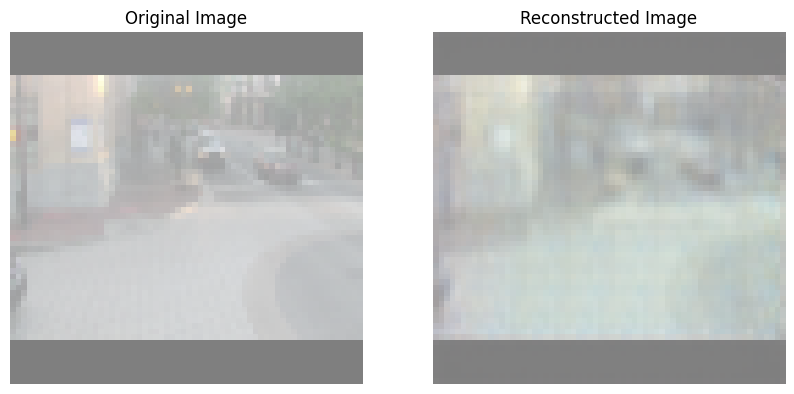

0.0013447839301079512

In [48]:
# normal image
normal_image = "data/SmallerDataset/Test/Normal_Videos_912_x264_340.png"
visualize_reconstruction(model,  normal_image, transform, device=device)

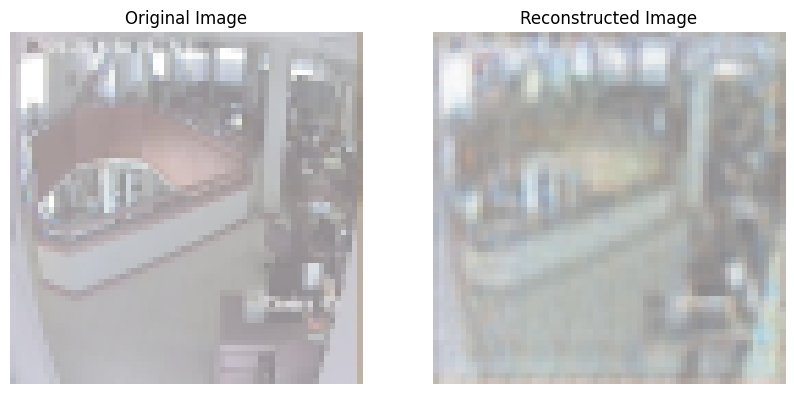

0.004685198422521353

In [49]:
normal_image_2 = "data/SmallerDataset/Test/Normal_Videos_923_x264_10660.png"
visualize_reconstruction(model,  normal_image_2, transform, device=device)

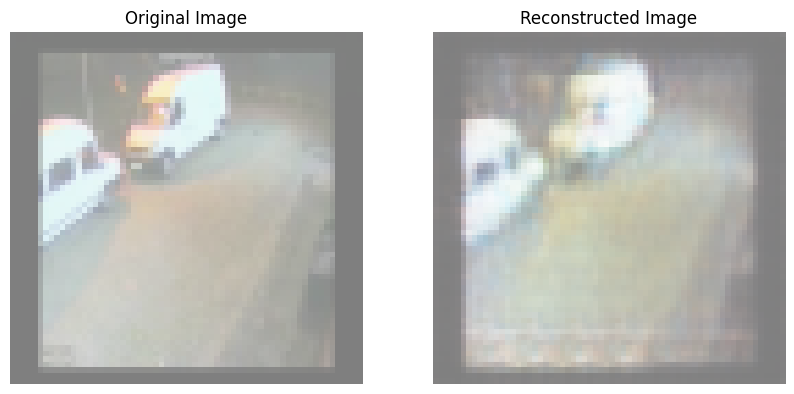

0.003439822932705283

In [50]:
# anomaly images
anomaly_1 = "data/SmallerDataset/AnomalyImages/Arson010_x264_1460.png"
visualize_reconstruction(model,  anomaly_1, transform, device=device)


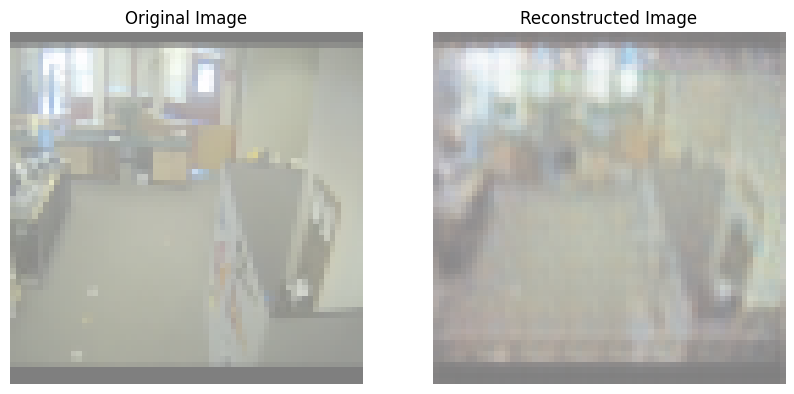

0.0030414797365665436

In [51]:
anomaly_2 = "data/SmallerDataset/AnomalyImages/Arrest001_x264_480.png"
visualize_reconstruction(model,  anomaly_2, transform, device=device)

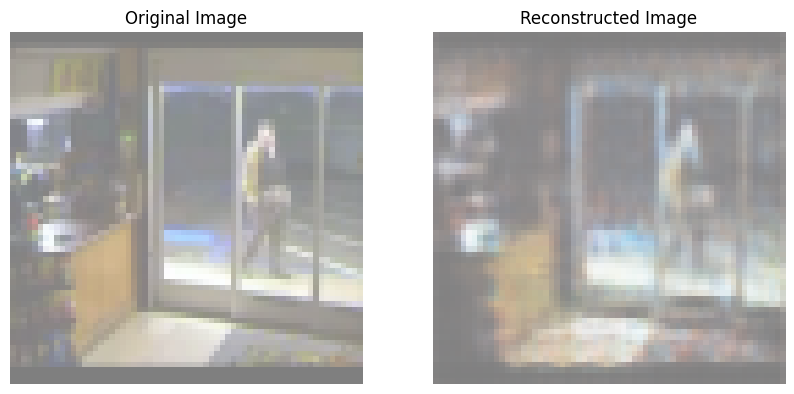

0.005787357687950134

In [52]:
anomaly_3 = "data/SmallerDataset/AnomalyImages/Vandalism017_x264_540.png"
visualize_reconstruction(model, anomaly_3, transform, device=device)

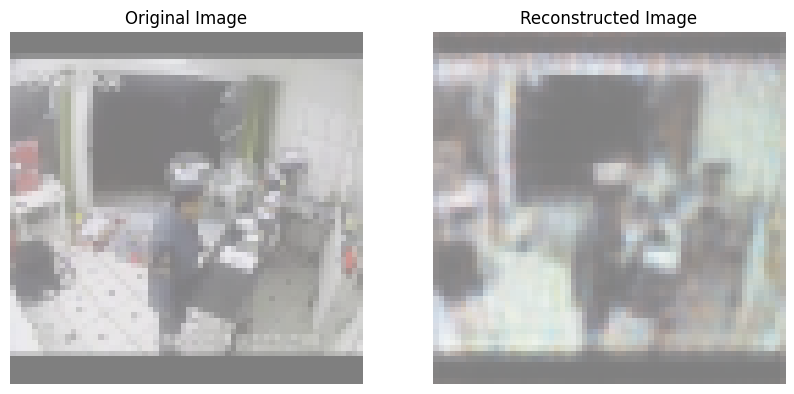

0.006543304771184921

In [53]:
anomaly_4 = "data/SmallerDataset/AnomalyImages/Shooting011_x264_3980.png"
visualize_reconstruction(model, anomaly_4, transform, device=device)